In [9]:
import numpy as np
from numpy.lib.stride_tricks import as_strided
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [2]:
img = imageio.imread('../../datas/f3.jpg')

In [4]:
def rolling_block(A, block=(3, 3)):
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = (A.strides[0], A.strides[1]) + A.strides
    return as_strided(A, shape=shape, strides=strides)

In [6]:
r,g,b = img[:,:,0],img[:,:,1],img[:,:,2]

In [8]:
dr = rolling_block(r)
dg = rolling_block(g)
db = rolling_block(b)

In [10]:
dst = cv2.merge([dr,dg,db])

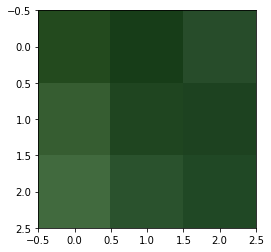

In [18]:
plt.imshow(dst[1,2])

In [12]:
print(dst.shape,dst.dtype)

(298, 398, 3, 3, 3) uint8


In [19]:
from itertools import product
def segment_and_concatenate(M, fun=None, blk_size=(16,16), overlap=(0,0)):
    # truncate M to a multiple of blk_size
    M = M[:M.shape[0]-M.shape[0]%blk_size[0], 
          :M.shape[1]-M.shape[1]%blk_size[1]]
    rows = []
    for i in range(0, M.shape[0], blk_size[0]):
        cols = []
        for j in range(0, M.shape[1], blk_size[1]):
            max_ndx = (min(i+blk_size[0], M.shape[0]),
                       min(j+blk_size[1], M.shape[1]))
            cols.append(fun(M[i:max_ndx[0], j:max_ndx[1]]))
        rows.append(np.concatenate(cols, axis=1))
    return np.concatenate(rows, axis=0)
from numpy.lib.stride_tricks import as_strided
def block_view(A, block= (3, 3)):
    """Provide a 2D block view to 2D array. No error checking made.
    Therefore meaningful (as implemented) only for blocks strictly
    compatible with the shape of A."""
    # simple shape and strides computations may seem at first strange
    # unless one is able to recognize the 'tuple additions' involved ;-)
    shape= (A.shape[0]/ block[0], A.shape[1]/ block[1])+ block
    strides= (block[0]* A.strides[0], block[1]* A.strides[1])+ A.strides
    return as_strided(A, shape= shape, strides= strides)
def segmented_stride(M, fun, blk_size=(3,3), overlap=(0,0)):
    # This is some complex function of blk_size and M.shape
    stride = blk_size
    output = np.zeros(M.shape)
    B = block_view(M, block=blk_size)
    O = block_view(output, block=blk_size)
    for b,o in zip(B, O):
        o[:,:] = fun(b);
    return output
def view_process(M, fun=None, blk_size=(16,16), overlap=None):
    # truncate M to a multiple of blk_size
    from itertools import product
    output = np.zeros(M.shape)
    dz = np.asarray(blk_size)
    shape = M.shape - (np.mod(np.asarray(M.shape), 
                          blk_size))
    for indices in product(*[range(0, stop, step) 
                        for stop,step in zip(shape, blk_size)]):
        # Don't overrun the end of the array.
        #max_ndx = np.min((np.asarray(indices) + dz, M.shape), axis=0)
        #slices = [slice(s, s + f, None) for s,f in zip(indices, dz)]
        output[indices[0]:indices[0]+dz[0], 
               indices[1]:indices[1]+dz[1]][:,:] = fun(M[indices[0]:indices[0]+dz[0], 
               indices[1]:indices[1]+dz[1]])
    return output
if __name__ == "__main__":
    R = np.random.rand(128,128)
    squareit = lambda(x):x*2
    from timeit import timeit
    t ={}
    kn = np.array(list(product((8,16,64,128), 
                               (128, 512, 2048, 4096))  ) )
    methods = ("segment_and_concatenate", 
               "view_process", 
               "segmented_stride")    
    t = np.zeros((kn.shape[0], len(methods)))
    for i, (k, N) in enumerate(kn):
        for j, method in enumerate(methods):
            t[i,j] = timeit("""Rprime = %s(R, blk_size=(%d,%d), 
                          overlap = (0,0), 
                          fun = squareit)""" % (method, k, k),
                   setup="""
from segmented_processing import %s
import numpy as np
R = np.random.rand(%d,%d)
squareit = lambda(x):x**2""" % (method, N, N),
number=5
)
        print "k =", k, "N =", N #, "time:", t[i]
        print ("    Speed up (view vs. concat, stride vs. concat): %0.4f, %0.4f" % (
                       t[i][0]/t[i][1], 
                       t[i][0]/t[i][2]))

SyntaxError: invalid syntax (<ipython-input-19-14bb33e1e172>, line 52)